
#  AI Brain Tumor Detection Prototype

This notebook demonstrates a working prototype of brain tumor detection using **three saved models**:

###  Method 1:
1. **U-Net Segmentation** (`best_unet_model.keras`)
2. **Tumor Cropping**
3. **EfficientNet Classification** (`U-Net_EfficientNet_classification.keras` with 128x128 input)

###  Method 2:
- **Direct Classification** using EfficientNet (`EfficientNet_classification.keras` with 128x128 input)

The test image is randomly selected from the test split.


In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from glob import glob
import random


In [27]:
# Class labels and paths
class_names = ['glioma', 'meningioma', 'pituitary']
IMG_SIZE_DIRECT = 128
IMG_SIZE_CROPPED = 128

# Load models
unet_model = load_model("best_unet_model.keras")
unet_classifier = load_model("U-Net_EfficientNet_classification.keras")
direct_classifier = load_model("Only_Claasification\EfficientNet_classification.keras")

print("All models loaded.")


All models loaded.


In [28]:
# Dataset paths
split_test_path = r"D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\processed\split\test"
cropped_test_path = r"D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\cropped\test"

# Pick a random image path from test set
cls = random.choice(class_names)
image_path = glob(os.path.join(split_test_path, "images", cls, "*.png"))[0]
mask_path = os.path.join(split_test_path, "masks", cls, os.path.basename(image_path))
cropped_path = os.path.join(cropped_test_path, cls, os.path.basename(image_path))

print("Selected test image:", image_path)
print("Selected test image mask:", mask_path)
print("Selected test cropped image:", cropped_path)


Selected test image: D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\processed\split\test\images\meningioma\10.png
Selected test image mask: D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\processed\split\test\masks\meningioma\10.png
Selected test cropped image: D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\cropped\test\meningioma\10.png


In [29]:
def crop_from_mask(image, mask):
    mask = (mask > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return image[y:y+h, x:x+w]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


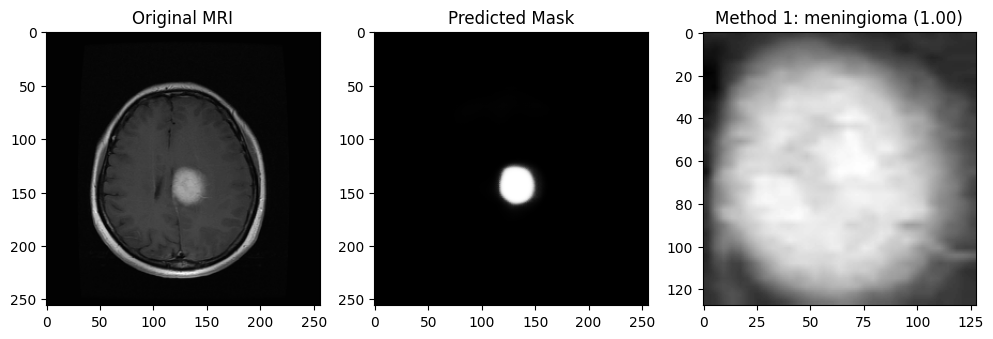

In [30]:
# Load grayscale image and prepare for U-Net
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image_gray, (256, 256)) / 255.0
input_unet = np.expand_dims(image_resized[..., np.newaxis], axis=0)
pred_mask = unet_model.predict(input_unet)[0].squeeze()

# Crop using mask
cropped = crop_from_mask(image_gray, pred_mask)
if cropped is not None:
    cropped_resized = cv2.resize(cropped, (IMG_SIZE_CROPPED, IMG_SIZE_CROPPED))
    cropped_rgb = cv2.cvtColor(cropped_resized, cv2.COLOR_GRAY2RGB)
    input_crop = preprocess_input(np.expand_dims(cropped_rgb, axis=0).astype(np.float32))

    pred1 = unet_classifier.predict(input_crop)[0]
    class1 = class_names[np.argmax(pred1)]
    conf1 = np.max(pred1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Original MRI")
    plt.imshow(image_gray, cmap='gray')
    plt.subplot(1,3,2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.subplot(1,3,3)
    plt.title(f"Method 1: {class1} ({conf1:.2f})")
    plt.imshow(cropped_resized, cmap='gray')
    plt.show()
else:
    print("No tumor region detected by U-Net.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


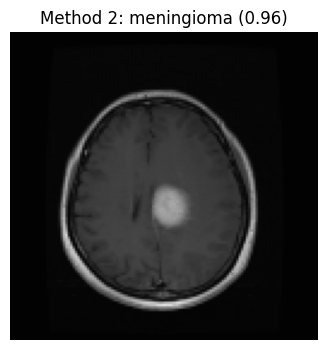

In [31]:
# Method 2: Direct classification
image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
image_direct = cv2.resize(image_rgb, (IMG_SIZE_DIRECT, IMG_SIZE_DIRECT))
input_direct = preprocess_input(np.expand_dims(image_direct, axis=0))

pred2 = direct_classifier.predict(input_direct)[0]
class2 = class_names[np.argmax(pred2)]
conf2 = np.max(pred2)

plt.figure(figsize=(4,4))
plt.title(f"Method 2: {class2} ({conf2:.2f})")
plt.imshow(image_direct)
plt.axis('off')
plt.show()
